# TODO 
## Clean Up and Add Comment

# Notebook used to monitor how Reactions move through comparisonTST workflow

## Importing Required Modules

In [1]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)
import os
import re
import numpy as np
from collections import defaultdict, OrderedDict
import pandas as pd
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
import itertools
import IPython
from IPython.display import display, Markdown
def mprint(s): display(Markdown(s))
import cPickle as pickle
from graphviz import Digraph
# attempt at making the cells wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Function for Determing if Species is Reactant or Product

In [2]:
def isReactantOrProduct(self, reactant):
        """
        Checks to see if a certiant rmgpy.molecule object is in 
        either the reactants side or products side of rmgpy.reaction
        
        Inputs: 
        self (rmgpy.reaction)
        reactant (rmgpy.molecule)
        
        Output:
        result (bool) - True if reactant is in the reaction, Fasle if not.
        """
        
        if reactant in self.reactants:
            gotOne = True
        elif reactant in self.products:
            gotOne = True
        else: 
            gotOne = False
        return gotOne
    
#self = df.iloc[0,1]
#reactant = Molecule(SMILES="OO")
#isReactantOrProduct(self, reactant)

# Function for getting Results Dict. from Log File

In [12]:
def get_dict_from_log(filepath, exceptions):
    
    # using these bools to make the code more readable when if statements are needed later on
    # initializing to false for every reaction, not very elegant or pythonic
    A = False
    B = False
    C1 = False
    C2 = False
    D1 = False
    D2 = False
    E1 = False
    E2 = False
    F1 = False
    F2 = False
    G = False
    H = False
    I = False
    J1 = False
    J2 = False
    K = False
    L = False
    M = False
    M2 = False
    N = False
    Y1 = False
    Y2 = False
    Z = False
    err = False
    ZZZ = False
    
    # looks atrocious and feels even worse to keep this in here
    # used to make sure the DF has all relavent indexes for creation of flow chart in DF_to_workflow()
    r = OrderedDict()
    r['... Gaussian Error'] = np.nan
    r['... Symmetry Not in Path Error'] = np.nan
    r['... Value Error'] = np.nan
    r['... incorrect_connectivity'] = np.nan
    r['... Raises Exception'] = np.nan
    r['... Not OOH Abstraction'] = np.nan
    r['0.1 Reaction Str'] = np.nan
    r['1 log file exists'] = np.nan
    r['1 log file exists and Complete'] = np.nan
    r['1 log file exists and Success'] = np.nan
    r['A and Complete'] = np.nan
    r['A and Success'] = np.nan
    r['A: Matched H Abstraction'] = np.nan
    r['B and Complete'] = np.nan
    r['B and Success'] = np.nan
    r['B: Checked for Existing Kinetic File'] = np.nan
    r['C1 and Complete'] = np.nan
    r['C1 and Success'] = np.nan
    r['C1: Kinetics File Already Exists'] = np.nan
    r['C2 and Complete'] = np.nan
    r['C2 and Success'] = np.nan
    r['C2: Needs New Kinetic File -> TS Direct Guess'] = np.nan
    r['D1 and Complete'] = np.nan
    r['D1 and Success'] = np.nan
    r['D1: Found Existing TS File'] = np.nan
    r['D2 and Complete'] = np.nan
    r['D2 and Success'] = np.nan
    r['D2: No Existing TS. Direct Guess Generated'] = np.nan
    r['E1 and Complete'] = np.nan
    r['E1 and Success'] = np.nan
    r['E1: Reading Existing TS File'] = np.nan
    r['E2 and Complete'] = np.nan
    r['E2 and Success'] = np.nan
    r['E2: Started TS Optimization Search'] = np.nan
    r['F1 and Complete'] = np.nan
    r['F1 and Success'] = np.nan
    r['F1: TS Attempt 1'] = np.nan
    r['F2 and Complete'] = np.nan
    r['F2 and Success'] = np.nan
    r['F2: Previous TS optimization complete'] = np.nan
    r['G and Complete'] = np.nan
    r['G and Success'] = np.nan
    r['G: TS Attempt 2'] = np.nan
    r['J1 and Complete'] = np.nan
    r['J1 and Success'] = np.nan
    r['J1: Saving Valid TS File'] = np.nan
    r['J2 and Complete'] = np.nan
    r['J2 and Success'] = np.nan
    r['J2: Could Not Create Valid TS File'] = np.nan
    r['K and Complete'] = np.nan
    r['K and Success'] = np.nan
    r['K: Starting Symmetry Calculation'] = np.nan
    r['L and Complete'] = np.nan
    r['L and Success'] = np.nan
    r['L: Symmetry Calculation Successful'] = np.nan
    r['M and Complete'] = np.nan
    r['M and Success'] = np.nan
    r['M2 and Complete'] = np.nan
    r['M2 and Success'] = np.nan
    r['M2: CanTherm Barrier Height Problem'] = np.nan
    r['M: CanTherm Started'] = np.nan
    r['Y1: Overall Success'] = np.nan
    r['Y2: Overall Fail'] = np.nan
    r['Z Complete'] = np.nan
     r['... Filepath'] = np.nan
    
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    
    # using with to open file, read contents, then close file
    with open(filepath) as f:
        lines = f.readlines()
    
    for l in lines:

        if "chemkinRxn" in l:
            rxn = l.split("chemkinRxn: ")[-1]
            
            rxn = eval(rxn)
            
            # checking it is OOH abstraction
            if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))):
                r['... Not OOH Abstraction'] = 1
            
            #r['0 reaction'] = rxn # Commented out beause of difficulties of using DataFrame.drop_duplicates with RMG.reaction objects
            r['0.1 Reaction Str'] = repr(rxn)
        
        # adding checkpoints to r dict
        # If confused about arrangment in workflow, use the flowchart generator for a better visualization
        if 'We have generated a H_Abstraction reaction' in l:
            r['A: Matched H Abstraction'] = 1
            A = True
        
        if 'Calculating kinetic data' in l:
            r['B: Checked for Existing Kinetic File'] = 1
            B = True

        if 'Reading existing kinetics file' in l:
            r['C1: Kinetics File Already Exists'] = 1
            C1 = True       
        if 'Generating a TS geometry via the direct guess method' in l:
            r['C2: Needs New Kinetic File -> TS Direct Guess'] = 1
            C2 = True
        
        if 'exists. Loading it to save time' in l:
            r['D1: Found Existing TS File'] = 1
            D1 = True
        if 'TS estimate made. About to try the search' in l:
            r['D2: No Existing TS. Direct Guess Generated'] = 1
            D2 = True
            
        if 'Reading existing ts file' in l:
            r['E1: Reading Existing TS File'] = 1
            E1 = True
            
        if 'Starting optimization steps of the TS search' in l:
            r['E2: Started TS Optimization Search'] = 1
            E2 = True

        if 'Optimizing TS attempt 1' in l:
            r['F1: TS Attempt 1'] = 1
            F1 = True
        if 'optimizeTS INFO Output file' in l and 'exists and looks complete. Trying that.' in l:
            r['F2: Previous TS optimization complete'] = 1
            F2 = True
            
        if 'Optimizing TS attempt 2' in l:
            r['G: TS Attempt 2'] = 1
            G = True
        
        if 'Optimizing TS attempt 1 but with quadratic scf' in l:
            r['H: TS Attempt 1 but with Quadratic SCF'] = 1
            H = True
        
        if 'Optimizing TS attempt 2 but with quadratic scf' in l:
            r['I: TS Attempt 2 but with Quadratic SCF'] = 1
            I = True
            
        if 'Saving TS result file' in l:
            r['J1: Saving Valid TS File'] = 1
            J1 = True
        if "Couldn't find transition state. Not using TST" in l:
            r['J2: Could Not Create Valid TS File'] = 1
            J2 = True
 
        if 'Symmetry input file written to' in l:
            r['K: Starting Symmetry Calculation'] = 1
            K = True
        
        if 'Point group:' in l:
            r['L: Symmetry Calculation Successful'] = 1
            L = True

        if 'CanTherm execution initiated' in l:
            r['M: CanTherm Started'] = 1
            M = True
        if 'Successful kinetics calculation in CanTherm' in l:
            r['M1: CanTherm Success'] = 1
            M1 = True
        if 'One or both of the barrier heights of' in l:
            r['M2: CanTherm Barrier Height Problem'] = 1
            M2 = True

        if 'Successful kinetics calculation in CanTherm' in l:
            r['N: CanTherm Success'] = 1
            N = True

        if 'Yay, reaction kinetics calculated' in l:
            r['Y1: Overall Success'] = 1
            Y1 = True           
        if "Boo, reaction kinetics not calculated" in l:
            r['Y2: Overall Fail'] = 1
            Y2 = True
        
        # 'raise Exception' is often found in log files of reactions that should be rerun
        if 'raise Exception' in l:
            r['... Raises Exception'] = 1
            
            if l in exceptions.keys(): # used to see all of the exceptions that have been raised. Be careful that this list will not be trimmed if the DF is trimmed later on
                exceptions[l] = exceptions[l] + 1
            else:
                exceptions[l] = 1
        # Errors I've seen that may warrent a rerun       
        if "Couldn't find Gaussian executable at" in l:
            r['... Gaussian Error'] = 1
        if 'Incorrect connectivity for optimized geometry in file' in l:
            r['... incorrect_connectivity'] = l
        if "Please check if symmetry program is installed on your system in RMG-Py/bin/symmetry" in l:
            r['... Symmetry Not in Path Error'] = 1
        if 'ValueError: invalid literal for float' in l:
            r['... Value Error'] = 1
    
    # Instead of Looking at Lines, now looking at overall Reaction Path
    if Y1 or Y2:
        r['Z Complete'] = 1
        Z = True

    # used to see how many completions come from a certain point (A, B, C1,...)
    # Z = true when Complete
    # certain points are missing becuase they yield 0 since discovery does not have those log messages yet
    if Z and '1 log file exists' in r.keys():
        r['1 log file exists and Complete'] = 1
    if Z and A:
        r['A and Complete'] = 1
    if Z and B:
        r['B and Complete'] = 1
    if Z and C1:
        r['C1 and Complete'] = 1
    if Z and C2:
        r['C2 and Complete'] = 1
    if Z and D1:
        r['D1 and Complete'] = 1
    if Z and D2:
        r['D2 and Complete'] = 1
    if Z and E1:
        r['E1 and Complete'] = 1
    if Z and E2:
        r['E2 and Complete'] = 1
    if Z and F1:
        r['F1 and Complete'] = 1
    if Z and F2:
        r['F2 and Complete'] = 1
    if Z and G:
        r['G and Complete'] = 1
    if Z and J1:
        r['J1 and Complete'] = 1
    if Z and J2:
        r['J2 and Complete'] = 1
    if Z and K:
        r['K and Complete'] = 1
    if Z and L:
        r['L and Complete'] = 1
    if Z and M:
        r['M and Complete'] = 1
    if Z and M2:
        r['M2 and Complete'] = 1

    # used to find number of successes from a certain point
    # Y1 = True when successful
    if Y1 and '1 log file exists' in r.keys():
        r['1 log file exists and Success'] = 1
    if Y1 and A:
        r['A and Success'] = 1
    if Y1 and B:
        r['B and Success'] = 1
    if Y1 and C1:
        r['C1 and Success'] = 1
    if Y1 and C2:
        r['C2 and Success'] = 1
    if Y1 and D1:
        r['D1 and Success'] = 1
    if Y1 and D2:
        r['D2 and Success'] = 1
    if Y1 and E1:
        r['E1 and Success'] = 1
    if Y1 and E2:
        r['E2 and Success'] = 1
    if Y1 and F1:
        r['F1 and Success'] = 1
    if Y1 and F2:
        r['F2 and Success'] = 1
    if Y1 and G:
        r['G and Success'] = 1
    if Y1 and J1:
        r['J1 and Success'] = 1
    if Y1 and J2:
        r['J2 and Success'] = 1
    if Y1 and K:
        r['K and Success'] = 1
    if Y1 and L:
        r['L and Success'] = 1
    if Y1 and M:
        r['M and Success'] = 1
    if Y1 and M2:
        r['M2 and Success'] = 1
    
    if not Z:
        r['... Filepath'] = filepath
    
    return r, exceptions
print

IndentationError: unexpected indent (<ipython-input-12-daf7f31b018d>, line 98)

## Function for Making Flowchart of the Workflow from Data Frame

In [ ]:
# Function takes dataframe and makes it into a flowchart of the workflow

# Must have ALL specified indices (see below).
# Easiest to just force the DF to have all indices using get_dict_from_log()

def DF_to_workflow(DF_workflow):
    
    # From the data frame, getting summary data and storing as variables
    DF_workflow_summary = DF_workflow.count(axis = 1)
    start_count = DF_workflow_summary['1 log file exists']
    start_succ = DF_workflow_summary['1 log file exists and Success']
    start_comp = DF_workflow_summary['1 log file exists and Complete']

    A_count = DF_workflow_summary['A: Matched H Abstraction']
    A_succ = DF_workflow_summary['A and Success']
    A_comp = DF_workflow_summary['A and Complete']

    not_OOH = start_count - A_count

    B_count = DF_workflow_summary['B: Checked for Existing Kinetic File']
    B_succ = DF_workflow_summary['B and Success']
    B_comp = DF_workflow_summary['B and Complete']

    C1_count = DF_workflow_summary['C1: Kinetics File Already Exists']
    C1_comp = DF_workflow_summary['C1 and Complete']
    C1_succ = DF_workflow_summary['C1 and Success']

    C2_count = DF_workflow_summary['C2: Needs New Kinetic File -> TS Direct Guess']
    C2_comp = DF_workflow_summary['C2 and Complete']
    C2_succ = DF_workflow_summary['C2 and Success']
    
    B_to_C1_C2_DNF = B_count - (C1_count + C2_count)

    D1_count = DF_workflow_summary['D1: Found Existing TS File']
    D1_comp = DF_workflow_summary['D1 and Complete']
    D1_succ = DF_workflow_summary['D1 and Success']

    D2_count = DF_workflow_summary['D2: No Existing TS. Direct Guess Generated']
    D2_comp = DF_workflow_summary['D2 and Complete']
    D2_succ = DF_workflow_summary['D2 and Success']

    C1_to_D1_D2_DNF = C2_count - (D1_count + D2_count)

    E1_count = DF_workflow_summary['E1: Reading Existing TS File']
    E1_comp = DF_workflow_summary['E1 and Complete']
    E1_succ = DF_workflow_summary['E1 and Success']

    E2_count = DF_workflow_summary['E2: Started TS Optimization Search']
    E2_comp = DF_workflow_summary['E2 and Complete']
    E2_succ = DF_workflow_summary['E2 and Success']

    F1_count = DF_workflow_summary['F1: TS Attempt 1']
    F1_comp = DF_workflow_summary['F1 and Complete']
    F1_succ = DF_workflow_summary['F1 and Success']

    #TODO fix no key problem if count is zero
    F2_count = DF_workflow_summary['F2: Previous TS optimization complete']
    F2_comp = DF_workflow_summary['F2 and Complete']
    F2_succ = DF_workflow_summary['F2 and Success']

    E2_to_F1_F2_DNF = E2_count - (F1_count + F2_count)

    G_count = DF_workflow_summary['G: TS Attempt 2']
    G_comp = DF_workflow_summary['G and Complete']
    G_succ = DF_workflow_summary['G and Success']

    J1_count = DF_workflow_summary['J1: Saving Valid TS File']
    J1_comp = DF_workflow_summary['J1 and Complete']
    J1_succ = DF_workflow_summary['J1 and Success']

    #TODO uncomment when fixed
    J2_count = DF_workflow_summary['J2: Could Not Create Valid TS File']
    J2_comp = DF_workflow_summary['J2 and Complete']
    J2_succ = DF_workflow_summary['J2 and Success']

    F1_F2_to_J1_J2_DNF = (F1_count + F2_count) - (J1_count + J2_count)

    K_count = DF_workflow_summary['K: Starting Symmetry Calculation']
    K_comp = DF_workflow_summary['K and Complete']
    K_succ = DF_workflow_summary['K and Success']

    E1_J1_to_K_DNF = (E1_count + J1_count) - K_count

    L_count = DF_workflow_summary['L: Symmetry Calculation Successful']
    L_comp = DF_workflow_summary['L and Complete']
    L_succ = DF_workflow_summary['L and Success']

    K_to_L_DNF = K_count - L_count

    M_count = DF_workflow_summary['M: CanTherm Started']
    M_comp = DF_workflow_summary['M and Complete']
    M_succ = DF_workflow_summary['M and Success']

    L_to_M_DNF = L_count - M_count

    M_to_Y1_Y2_DNF = M_count - M_comp
    
    M_fail = M_comp - M_succ

    M2_count = DF_workflow_summary['M2: CanTherm Barrier Height Problem']
    M2_comp = DF_workflow_summary['M2 and Complete']
    M2_succ = DF_workflow_summary['M2 and Success']

    overall_success = DF_workflow_summary['Y1: Overall Success']
    overall_failure = DF_workflow_summary['Y2: Overall Fail']
    overall_complete = DF_workflow_summary['Z Complete']

    overall_DNF = A_count - (overall_success + overall_failure)

    ##########################################################################
    
    # making sure flowchart varaible is empty, without this it will keep adding edges
    flowchart = None
    flowchart = Digraph('comparisonTST', filename = 'comparisonTSTflowchart.gv')
    
    # Default attributes of node
    flowchart.attr('node', color = 'white', fontcolor = 'black', shape = 'rectangle', style = 'filled')

    # Adding Nodes
    flowchart.node('start', color = 'darkgoldenrod2', fontcolor = 'navy', label = "{} | {} | {}\n\nLog File Exists".format(start_count, start_comp, start_succ), shape = 'box')

    flowchart.node('matchH', label = "{} | {} | {}\n\nA1: Check H Abstraction\ncomparisonTST.py:215\n'generated a H_Abstraction reaction'".format(A_count, A_comp, A_succ), color = 'goldenrod2')
    flowchart.node('notOOHabstraction', label = "{}\n\nA2: Not OOH Abstraction".format(not_OOH), color = 'blueviolet', fontcolor = 'white')

    flowchart.node('checkKin', label = "{} | {} | {}\n\nB: Check if Kinetics File Exists\ncomparisonTST.py:129\n'Calculating Kinetic Data'".format(B_count, B_comp, B_succ), shape = 'ellipse', color = 'goldenrod2')

    flowchart.node('checkKin_Exists', label = "{} | {} | {}\n\nC1: Kinetics File Already Exists\nreaction.py:96\n'Reading existing kinetics file'".format(C1_count, C1_comp, C1_succ), color = 'goldenrod2')

    flowchart.node('TSdirect', label = "{} | {} | {}\n\nC2: TS Geometry Direct Guess - Estimate\nreaction.py:522\n'Generating a TS geometry via the direct guess method'".format(C2_count, C2_comp, C2_succ), shape = 'ellipse', color = 'goldenrod2')
    flowchart.node('TSdirect_exists', label = "{} | {} | {}\n\nD1: Found Existing TS File\nreaction.py:539\n'exists. Loading it to save time'".format(D1_count, D1_comp, D1_succ), color = 'goldenrod2')
    flowchart.node('loadTSData', label = "{} | {} | {}\n\nE1:\nloadTSData()\nreaction.py:54\n'Reading existing ts file'".format(E1_count, E1_comp, E1_succ), color = 'goldenrod2')

    flowchart.node('TSdirect_generated', label = "{} | {} | {}\n\nD2: Direct Guess Generated\nreaction.py:561\n'TS estimate made. About to try the search'".format(D2_count, D2_comp, D2_succ), color = 'goldenrod2')

    flowchart.node('tsSearch', label = "Begin TS Search\n'tsSearch()'")
    flowchart.node('tsSearch_overallSuccess', label = "tsSearch Overall Success")
    flowchart.node('tsSearch_overallFail', label = "tsSearch Overall Fail")
    #####
    flowchart.node('validateTS', label = "Validate TS\n'validateTS()'")
    flowchart.node('validateTS_valid', label = "Valid TS")
    flowchart.node('validateTS_invalid', label = "Invalid TS")
    flowchart.node('validateTS_valid_writeAndSave', label = "{} | {} | {}\n\nJ1: Writes and Saves Valid TS\nreaction.py:572\n'Saving TS result file'".format(J1_count, J1_comp, J1_succ), color = 'goldenrod2')
    #####
    flowchart.node('TSdirect_overallFalse', label = "TS Direct Guess Overall False")
    flowchart.node('TSdirect_overallTrue', label = "TS Direct Guess Overall True")

    flowchart.node('Updates_TSdist_training_database', label = "Should Update TS Distance Training Database\nCode Itself Looks Incomplete and Needs Work", color = 'red', fontcolor = 'white')
    #####
    flowchart.node('optimizeTS', label = "{} | {} | {}\n\nE2: Starts TS Optimization Search\nreaction.py:426\n'Starting optimization steps of the TS search'".format(E2_count, E2_comp, E2_succ), shape = 'ellipse', color = 'goldenrod2')

    flowchart.node('optimizeTS_outputAlreadyExists_complete', label = "{} | {} | {}\n\nF2: Output File Exists and is Complete\nreaction.py:438\n'exists and looks complete. Trying that'".format(F2_count, F2_comp, F2_succ), color = 'goldenrod2')
    flowchart.node('optimizeTS_outputAlreadyExists_complete_verify', label = "Verify Output File\n'verifyOutputFile()'")
    flowchart.node('optimizeTS_outputDNE_newInput', label = "{} | {} | {}\n\nF1: Create and Run New Input\nTS Attempt 1\nreaction.py:444\n'Optimizing TS attempt 1'\n'createInputFile()' & 'self.run()'".format(F1_count, F1_comp, F1_succ), color = 'goldenrod2')
    flowchart.node('optimizeTS_outputDNE_newInput_VOF', label = "Verify Output File\n'verifyOutputFile()'")
    flowchart.node('optimizeTS_checkIntCoord', label = "Check Internal Coordinates && Convergence", shape = 'ellipse')
    flowchart.node('optimizeTS_checkIntCoord_Conv', label ="Internal Coordinates Failed or TS Converged")
    flowchart.node('optimizeTS_checkIntCoord_DNC', label = "{} | {} | {}\n\nG: Internal Coord. Success but Diverged\nTS Attempt 2\nreaction.py:453\n'Optimizing TS attempt 2'\n'createInputFile()' & 'self.run()'".format(G_count, G_comp, G_succ), color = 'goldenrod2')
    flowchart.node('optimizeTS_checkIntCoord_DNC_VOF', label = "Verify Output File\n'verifyOutputFile()'")
    flowchart.node('optimizeTS_checkConv', label = "Checks Convergence", shape = 'ellipse')
    flowchart.node('optimizeTS_checkConv_converged', label = "Converged")
    flowchart.node('optimizeTS_checkConv_DNC', label = "Not Converged. Checks for Convergence Failures\n'checkComplete()'", shape = 'ellipse')
    flowchart.node('optimizeTS_checkConv_DNC_convFailure', label = "H: Convergence Failure\nreaction.py:464\n'Optimizing TS attempt 1 but with Quadratic SCF'\n'createInputFile()' & 'self.run()'", color = 'black', style = 'solid')
    flowchart.node('optimizeTS_checkConv_DNC_convFailure_VOF', label = "Verify Output File\n'verifyOutputFile()'")
    flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', label = "Checks Internal Coordinates", shape = 'ellipse')
    flowchart.node('optimizeTS_checkConv_DNC_convSuccess', label = "No Convergence Failures")
    flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc', label = "I: Internal Coordinates Success\nreaction.py.468\n'Optimizing TS attempt 2 but with Quadratic SCF'\n'createInputFile()' & 'self.run()'", color = 'black', style = 'solid')
    flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', label = "Verify Output File\n'verifyOutputFile()'")
    flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail', label = "Internal Coordinates Failure")

    flowchart.node('optimizeTS_overallSuccess', label = "optimizeTS Overall Success")
    flowchart.node('optimizeTS_overallFail', label = "optimizeTS overall Failure")
    #####
    flowchart.node('symmetry_start', label = "{} | {} | {}\n\nK:\nSymmetry Calculation Started".format(K_count, K_comp, K_succ), color = 'goldenrod2')
    flowchart.node('symmetry_success', label = "{} | {} | {}\n\nL:\nSuccesful Symmetry Calculation".format(L_count, L_comp, L_succ), color = 'goldenrod2')

    flowchart.node('canTherm', label = "{} | {} | {}\n\nM: CanTherm Started\n'CanTherm execution initiated'".format(M_count, M_comp, M_succ), shape = 'ellipse', color = 'goldenrod2')
    flowchart.node('canTherm_fail', label = "{} | CanTherm Fails\n{} | Barrier Height Fails".format(M_fail,M2_count), color = 'gold')
    flowchart.node('canTherm_success', label = "CanTherm Success\nreaction.py:879\n'Succesful kinetics calculation in CanTherm'", color = 'black', style = 'solid')

    flowchart.node('TSoverallFail', label = "{} | {} | {}\n\nJ2: TS Fail\nreaction.py:844\n'Couldn't find transition state. Not using TST'".format(J2_count, J2_comp, J2_succ), color = 'goldenrod2')
    flowchart.node('overallFail', label = "{}   Failed\n\nY2: Overall Fail\ncomparisonTST.py:142\n'Boo, reaction kinetics not calculated'".format(overall_failure), color = 'goldenrod2')
    flowchart.node('overallSuccess', label = "{}   Succeeded\n\nY1: Yay! Kinetics Succesful\ncomparisonTST.py:139\n'Yay, reaction kinetics calculated'".format(overall_success), color = 'goldenrod2')

    # DNF nodes
    flowchart.node('checkKin_DNF', label = "{} | 0 | 0\nB to C1 & C2".format(B_to_C1_C2_DNF), color = 'red', style = 'solid')
    flowchart.node('TSdirect_DNF', label = "{} | 0 | 0\nC2 to D2 & D1".format(C1_to_D1_D2_DNF), color = 'red', style = 'solid')
    flowchart.node('optimizeTS_DNF', label = "{} | 0 | 0\nE2 to F1 & F2".format(E2_to_F1_F2_DNF), color = 'red', style = 'solid')
    flowchart.node('optimizeTS_checkConv_DNF', label = "{} | 0 | 0\nF1 & F2 to J1 & J2".format(F1_F2_to_J1_J2_DNF), color = 'red', style = 'solid')
    flowchart.node('TSdirect_overallTrue_DNF', label = "{} | 0 | 0\nJ1 & E1 to K".format(E1_J1_to_K_DNF), color = 'red', style = 'solid')
    flowchart.node('symmetry_start_DNF', label = '{} | 0 | 0\nK to L'.format(K_to_L_DNF),color = 'red', style = 'solid')
    flowchart.node('symmetry_success_DNF', label = '{} | 0 | 0\nL to M'.format(L_to_M_DNF),color = 'red', style = 'solid')
    flowchart.node('canTherm_DNF', label = "{} | 0 | 0\nN to Y1 & Y2".format(M_to_Y1_Y2_DNF), color = 'red', style = 'solid')
    flowchart.node('overallDNF', label = "{}   DNF\n\nY3: Did Not Finish".format(overall_DNF), color = 'red', style = 'solid')

    # Legend node
    flowchart.node('Legend', label = "Number Explanation:\n# are HERE,   # COMPLETED from here,   # SUCCEEDED from here,\n\nColor Coding:\nGold  =  Has Log Messages and Numbers\nRed Outline  =  For Files that Did Not Finish (DNF)\nBlack Outline  =  Has Log Messages but Not on Discovery Version\nSolid Red  =  I am Concerned", color = 'cyan', style = 'solid')
    ##############
    
    # Adding Edges
    flowchart.edge('start', 'matchH')
    flowchart.edge('matchH', 'checkKin')
    flowchart.edge('start', 'notOOHabstraction')
    flowchart.edge('checkKin', 'checkKin_Exists')
    flowchart.edge('checkKin_Exists', 'overallSuccess')
    flowchart.edge('checkKin', 'TSdirect')
    flowchart.edge('TSdirect', 'TSdirect_DNF', style = 'dotted')
    flowchart.edge('TSdirect_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('TSdirect', 'TSdirect_exists')
    flowchart.edge('TSdirect_exists', 'loadTSData')
    flowchart.edge('loadTSData', 'TSdirect_overallTrue')
    flowchart.edge('TSdirect', 'TSdirect_generated')
    flowchart.edge('TSdirect_generated', 'tsSearch')
    flowchart.edge('tsSearch', 'optimizeTS')
    flowchart.edge('optimizeTS', 'optimizeTS_DNF', style = 'dotted')
    flowchart.edge('optimizeTS_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('optimizeTS', 'optimizeTS_outputDNE_newInput')
    flowchart.edge('optimizeTS_outputDNE_newInput', 'optimizeTS_outputDNE_newInput_VOF')
    flowchart.edge('optimizeTS_outputDNE_newInput_VOF', 'optimizeTS_checkIntCoord')
    flowchart.edge('optimizeTS', 'optimizeTS_outputAlreadyExists_complete')
    flowchart.edge('optimizeTS_outputAlreadyExists_complete', 'optimizeTS_outputAlreadyExists_complete_verify')
    flowchart.edge('optimizeTS_outputAlreadyExists_complete_verify', 'optimizeTS_checkIntCoord')
    flowchart.edge('optimizeTS_checkIntCoord', 'optimizeTS_checkIntCoord_DNC')
    flowchart.edge('optimizeTS_checkIntCoord_DNC', 'optimizeTS_checkIntCoord_DNC_VOF')
    flowchart.edge('optimizeTS_checkIntCoord_DNC_VOF', 'optimizeTS_checkConv')
    flowchart.edge('optimizeTS_checkIntCoord', 'optimizeTS_checkIntCoord_Conv')
    flowchart.edge('optimizeTS_checkIntCoord_Conv', 'optimizeTS_checkConv')
    flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_DNF', style = 'dotted')
    flowchart.edge('optimizeTS_checkConv_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_converged')
    flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_DNC')
    flowchart.edge('optimizeTS_checkConv_DNC', 'optimizeTS_checkConv_DNC_convFailure')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure', 'optimizeTS_checkConv_DNC_convFailure_VOF')
    flowchart.edge('optimizeTS_checkConv_DNC', 'optimizeTS_checkConv_DNC_convSuccess')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_VOF', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF')
    flowchart.edge('optimizeTS_checkConv_converged', 'optimizeTS_overallSuccess')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', 'optimizeTS_overallSuccess')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', 'optimizeTS_overallFail')
    flowchart.edge('optimizeTS_checkConv_DNC_convSuccess', 'optimizeTS_overallFail')
    flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail', 'optimizeTS_overallFail')
    flowchart.edge('optimizeTS_overallFail', 'tsSearch_overallFail')
    flowchart.edge('optimizeTS_overallSuccess', 'validateTS')
    flowchart.edge('validateTS', 'validateTS_valid')
    flowchart.edge('validateTS', 'validateTS_invalid')
    flowchart.edge('validateTS_valid', 'validateTS_valid_writeAndSave')
    flowchart.edge('validateTS_valid_writeAndSave', 'Updates_TSdist_training_database')
    flowchart.edge('Updates_TSdist_training_database', 'tsSearch_overallSuccess')
    flowchart.edge('tsSearch_overallSuccess', 'TSdirect_overallTrue')

    flowchart.edge('TSdirect_overallTrue', 'symmetry_start')
    flowchart.edge('symmetry_start', 'symmetry_success')
    flowchart.edge('symmetry_start', 'symmetry_start_DNF', style = 'dotted')
    flowchart.edge('symmetry_start_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('symmetry_success', 'canTherm')
    flowchart.edge('symmetry_success', 'symmetry_success_DNF', style = 'dotted')
    flowchart.edge('symmetry_success_DNF', 'overallDNF', style = 'dotted')

    flowchart.edge('checkKin', 'checkKin_DNF', style = 'dotted')
    flowchart.edge('checkKin_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('TSdirect_overallTrue', 'TSdirect_overallTrue_DNF', style = 'dotted')
    flowchart.edge('TSdirect_overallTrue_DNF', 'overallDNF', style = 'dotted')
    flowchart.edge('validateTS_invalid', 'tsSearch_overallFail')
    flowchart.edge('tsSearch_overallFail', 'TSdirect_overallFalse')
    flowchart.edge('TSdirect_overallFalse', 'TSoverallFail')
    flowchart.edge('TSoverallFail', 'overallFail')
    flowchart.edge('canTherm', 'canTherm_success')
    flowchart.edge('canTherm_success', 'overallSuccess')
    flowchart.edge('canTherm', 'canTherm_fail')
    flowchart.edge('canTherm_fail', 'overallFail')
    flowchart.edge('canTherm', 'canTherm_DNF', style = 'dotted')
    flowchart.edge('canTherm_DNF', 'overallDNF', style = 'dotted')

    return flowchart

## Function for Trimming Data Frame of Duplicate Reactions

In [ ]:
# DF is organized L->R by Completion > &Success > or_New TS > or_Existing TS > or_Existing Kinetics > Failure...

# Duplicate reactions are dropped and the first seen is saved, so the ordering above determines what will be saved

# Trimmed DF is returned


def trim_DF(DF):
    #print DF.shape

    #print '\t dropping NA Reactions'
    DF = DF.T.dropna(subset = ['0.1 Reaction Str']).T
    #print DF.shape

    #print '\t dropping Column Duplicates'
    DF = DF.T.drop_duplicates().T
    #print DF.shape

    
    #print '\t dropping Reaction Duplicates'
    
    #   sorting priorities: Completion > Success > New TS & S > Existing TS & S > Existing Kinetics & S > Failure
    DF = DF.T.sort_values(['Z Complete', 'Y1: Overall Success', 'D2: No Existing TS. Direct Guess Generated', 'D1: Found Existing TS File', 'C1: Kinetics File Already Exists']).T
    DF = DF.T.drop_duplicates(['0.1 Reaction Str'], keep = 'first').T
    #print DF.shape
    #print DF.T['Y1: Overall Success'].count()
    
    return DF

# Function for Merging Two DFs, and Replacing RXNs from the Designated 'old_DF'

In [ ]:
def merge_and_update(old_DF, new_DF):
    my_count = 0
    
    #print old_DF.shape

    for reaction in new_DF.T['0.1 Reaction Str']:
        old_DF = old_DF.T[old_DF.T['0.1 Reaction Str'] != reaction].T
    
    #print old_DF.shape
    
    DF = pd.concat([old_DF, new_DF], axis = 1, ignore_index = True)
    return DF

## Iterating Through Log Files and Creating DFS

In [13]:
exceptions = {}
#####################################################################################################
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)
for i in range(1,1048):
    #' {0:d}  '.format( ) ensures placement of integer
    if i < 1000:
        filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
        filepath = os.path.join(directory,filename)
    elif i < 1050:
        i_new = i - 999
        filename = 'AutoTST-comparer.updated.1.{0:d}.combined.log'.format(i_new)
        filepath = os.path.join(directory,filename)
        
    if not os.path.exists(filepath):
        continue
    
    r, exceptions = get_dict_from_log(filepath, exceptions)
    
    results[i] = r
        
first_DF = pd.DataFrame(results)
##################################################################################################### 
#####################################################################################################
results = defaultdict(OrderedDict)
directory = '/gss_gpfs_scratch/harms.n/comparerTST'

for i in range (1,151):
    filename = 'AutoTST-comparer.symmetry_rerun.1.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    
    if not os.path.exists(filepath):
        continue
    
    r, exceptions = get_dict_from_log(filepath, exceptions)
    results[i] = r

second_DF = pd.DataFrame(results)
#####################################################################################################
results = defaultdict(OrderedDict)
directory = '/gss_gpfs_scratch/harms.n/comparerTST'

for i in range(1,42):
    filename = 'AutoTST-comparer.gauss_rerun.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    
    if not os.path.exists(filepath):
        continue
    
    r, exceptions = get_dict_from_log(filepath, exceptions)
    results[i] = r

third_DF = pd.DataFrame(results)
#####################################################################################################
#####################################################################################################

In [21]:
exceptions = {}
results = defaultdict(OrderedDict)
directory = '/gss_gpfs_scratch/harms.n/comparerTST'

for i in range(1,1001):
    filename = 'AutoTST-comparer.again.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    
    if not os.path.exists(filepath):
        continue
    
    r, exceptions = get_dict_from_log(filepath, exceptions)
    results[i] = r

mystery_DF = pd.DataFrame(results)
#DF_to_workflow(mystery_DF)

In [23]:
def quick_stat(DF):
    matched_OOH = DF.count(axis = 1)['A: Matched H Abstraction']
    completed = DF.count(axis = 1)['Z Complete']
    successful = DF.count(axis = 1)['Y1: Overall Success']
    return 'Total: {} | Complete: {} | Succesful: {}'.format(matched_OOH, completed, successful)

print quick_stat(trim_DF(first_DF))
print quick_stat(trim_DF(second_DF))
print quick_stat(trim_DF(third_DF))
comp_DF = trim_DF(pd.concat([trim_DF(first_DF), trim_DF(second_DF), trim_DF(third_DF)], axis = 1, ignore_index = True))
print quick_stat(comp_DF)

Total: 645 | Complete: 523 | Succesful 330
Total: 130 | Complete: 125 | Succesful 110
Total: 20 | Complete: 7 | Succesful 1
Total: 645 | Complete: 616 | Succesful 436


## Creating Composite DF and Workflow

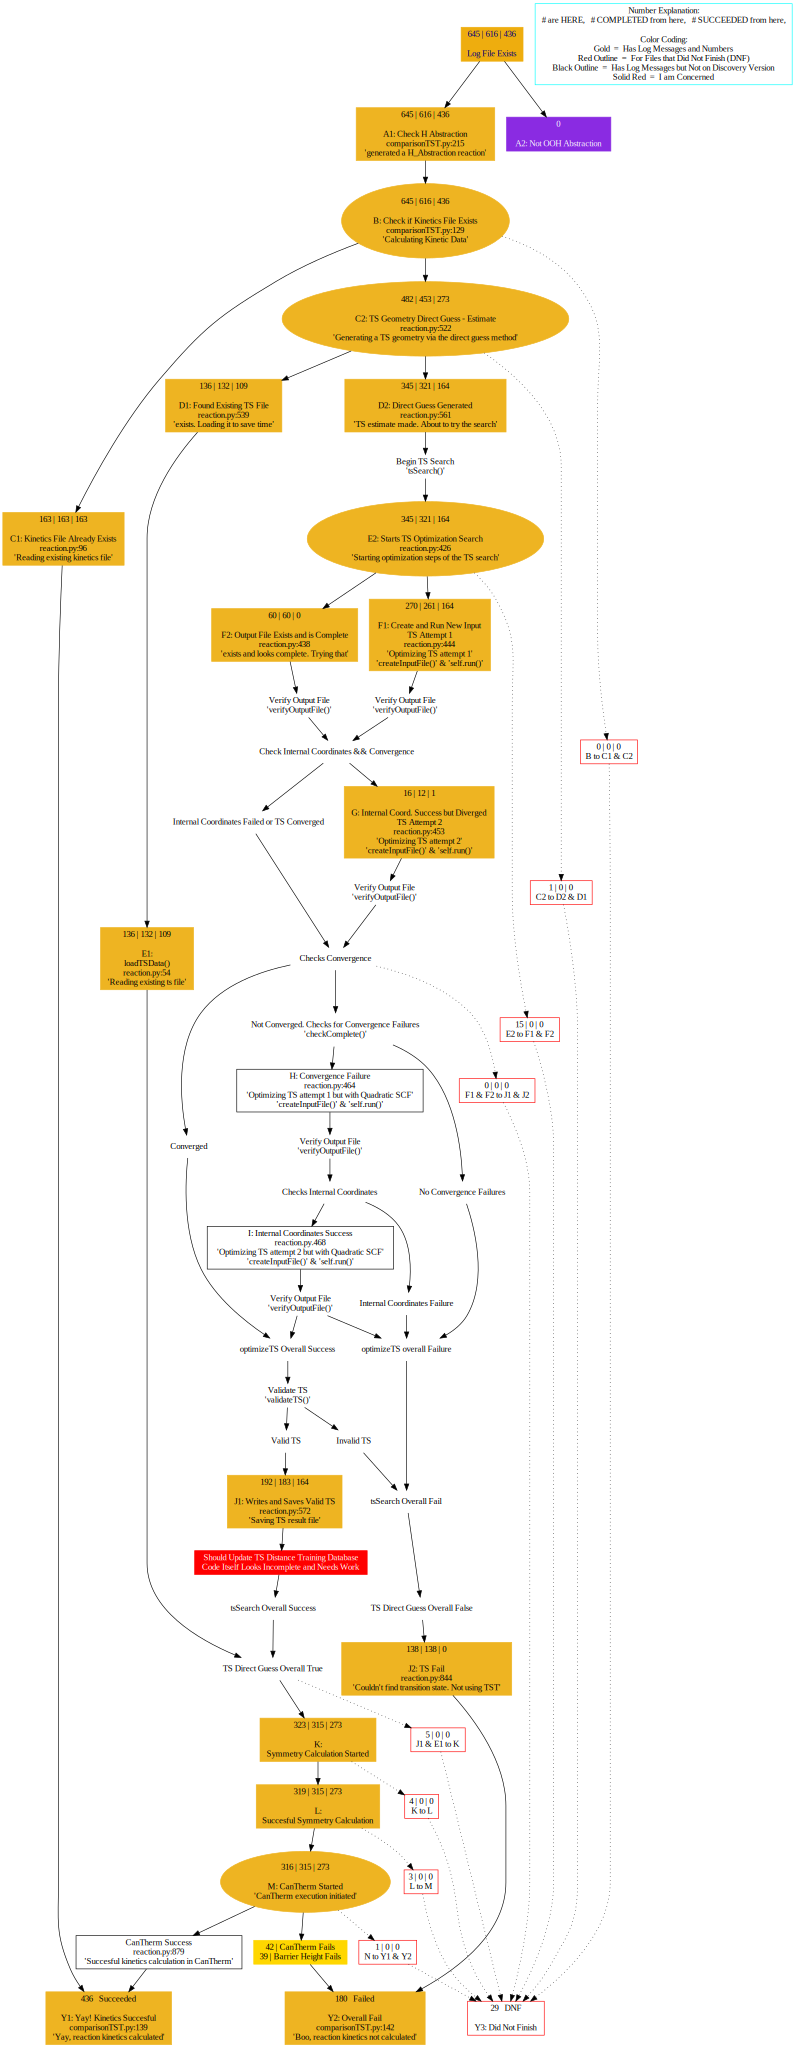

In [24]:
blem = DF_to_workflow(comp_DF)
blem

In [151]:
# Manually Found Copies That Evaded DataFrame.drop_duplicates without specific column
'<Molecule "CCCCC1C=CC=CC=1"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "CC[CH]CC1C=CC=CC=1">'
'<Molecule "C=CCCC1C=CC=CC=1"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=CC[CH]C1C=CC=CC=1">'
'<Molecule "CCC1=CC=C(C=O)O1"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C[CH]C1=CC=C(C=O)O1">'
'<Molecule "CCCC1C=CC=CC=1"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C[CH]CC1C=CC=CC=1">'
'<Molecule "CCCC(C)(C)C=O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "CC[CH]C(C)(C)C=O">'
'<Molecule "C=CCCC(C)C=O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=CCC[C](C)C=O">'

'<Molecule "C=CCCC(C)C=O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=CCC[C](C)C=O">'

# EYE CATCH : End of Modern Code

#
#
#
#
#
#
#
#


# Original Code : Preserved for Sample Code

In [ ]:
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)

#iterating over the list to count them
"""k = 0
for fil in comparerFiles:
    if ".log" in fil: # and "updated" in fil: # ask about including 'updated'
        k += 1"""
results = defaultdict(OrderedDict)

#place to store reactions that are not OOH abstractions
not_ooh_abstraction = []

# what do you seek?
successKey = 'Normal termination of Gaussian'
failKey = "Error termination"

# for 'index of log file' in range 'all log files'
for i in range(1,1050):
    r = results[i]
    
    #' {0:d}  '.format( ) ensures placement of integer
    if i < 1000:
        filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
        filepath = os.path.join(directory,filename)
    elif i < 1050:
        i_new = i - 999
        filename = 'AutoTST-comparer.updated.1.{0:d}.combined.log'.format(i_new)
        filepath = os.path.join(directory,filename)

    # reversing and making sure log file exists
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    
    # using with to open file, read contents, then close file
    with open(filepath) as f:
        lines = f.readlines()
    
    # j is iterator, while l is the line - enumerate splits these up
    for j,l in enumerate(lines):
        # set m to whatever is at the end of the line (reaction)
        #m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
        
        # if it 'performCalcs INFO reaction'
        if re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l):
            m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
            # "first parenthesized sub-group"
            rxn = eval(m.group(1))
            
            # checking it is OOH abstraction
            if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))): #Checking to make sure that 
                #not_ooh_abstraction = True
                return
            
            r['0 reaction'] = rxn
        
# adding 'checkpoints to r dict if they exist, changing around checkpoint name too'
# same
        if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
            r['2 matched H-abstraction'] = 1
# same
        if 'Reading existing kinetics file' in l:
            r['XX using existing kinetics data file'] = 1 # Reading in existing .kinetics file
# same        
        if 'Generating a TS geometry via the direct guess method' in l:
            r['3A started making TS geometry'] = 1
# same
        if "Reading existing ts file" in l:
            r['3B using existing TS data file'] = 1 # If reading in existing .ts file, this bypasses 4, 5 and 6

        #3C
# same
        if 'optimizeTS INFO Output file' in l and 'exists and looks complete. Trying that.' in l:
            r['3C Previous TS optimization complete'] = 1 #If reading in existing .log, this then checks if there is an existing IRC calc   
        
        if 'Running loose optimization of TS with frozen center' in l:
            r['4A TS opt w frozen center'] = 1    
        if 'Optimization of TS reaction center distances' in l:
            r['4B TS opt of rxn center'] = 1  
# Goes for two different optimization styles
        if 'Optimizing TS attempt' in l:
            r['4C TS optimization started'] = 1
        
        #5A
        # 'verifying...' prints whenever the file is being verified
        # do you want 5A=1 if TS is complete but does not have all the keywords for success?
# could get called more than one way
        if 'verifyOutputFile INFO Verifying output file' in l:
            r['5A New TS optimization complete'] = 1    
# could get called more than one way
        if 'Creating IRC file' in l:
            r['6A IRC file created'] = 1
# could get called more than one way
        if "Verifying the IRC output file" in l:
            r['6B New IRC calc complete'] = 1
# same
        if "saveTSData INFO Saving TS result file" in l:
            r['6C New IRC calc successful'] = 1   
# TODO add symmetry messages if wanted
        if 'Symmetry input file written to' in l:
            r['7A starting Symmetry calculation'] = 1
        if 'Point group:' in l:
            r['7B Symmetry calc successful'] = 1
            
        if 'CanTherm execution initiated' in l:
            r['8 CanTherm Started'] = 1
        if 'One or both of the barrier heights of' in l:
            r['8A CanTherm Barrier Height Problem'] = -1
# same
        if 'Yay, reaction kinetics calculated!!!' in l:
            r['ZZ overall success'] = 1
            r['ZZZ Complete'] = 1
# same            
        if "Boo," in l:
            r['ZZ overall fail'] = 1
            r['ZZZ Complete'] = 1
        
        if "gaussian.py:880 verifyIRCOutputFile ERROR Not all of the required keywords for success were found in the IRC output file!" in l:
            r['ZZZ IRC success keywords not found'] = 1

    # 'checkpoints' that require multiple other checkpoints
    if 'XX using existing TS data file' in r.keys() and 'ZZ overall success' in r.keys():
        r['YY successful prior calculation'] = 1
        
    if '5A New TS optimization complete' in r.keys() and '6A IRC file created' in r.keys():
        r['5B TS successfully optimized'] = 1
    
    if '6B New IRC calc complete' in r.keys() and "6A IRC file created" not in r.keys():
        r['6D IRC calc from previous calculation'] = 1
        del(r['6B New IRC calc complete'])
        
    if '5A New TS optimization complete' in r.keys() and '5C Previous TS optimization complete' in r.keys():
        del(r['5A New TS optimization complete'])
    
    if '3C Previous TS optimization complete' in r.keys() and 'ZZ overall success' in r.keys():
        r['000 3C and ZZ'] = 1
            
# creating pandas data frame (r.keys()as row titles)
dfold = pd.DataFrame(results)
#printing DF
#dfold
dfold.count(axis = 1)

### Pickling Shinanigans : Preserved for Sample Code

In [ ]:
f = open('dfsimple.pkl', 'w')
#pickle.dump(dfsimple, f)

In [ ]:
failed_reactions

In [ ]:
DNF

to_pickle = failed_reactions + DNF
len(to_pickle)
f = open("failed_reactions.pkl", "w")

#pickle.dump(to_pickle, f)

In [ ]:

f = open("progress_metering_dataframe.pkl", "w")
#pickle.dump(dfsimple, f)

In [ ]:
f = open("progress_metering_dataframe.pkl", "r")
#pickle.load(f)

# Following is only Preserved for Sample Code: Check Complete was Found to be Working Fine

## QM File Succeskey/Failkey Search Functions (used to double check checkComplete() ) :

In [ ]:
def checkSpeciesFile(filename, sucComp):
    allSuccesful, allComplete = sucComp
    
    reactOrProdFilePath = os.path.join(qmScratchDir, fileName)
    f = open(reactOrProdFilePath, "r")

    lines = f.readlines()
    # because each reaction needs multiple reactants/products to be checked,
    # this becomes more complicated
    
    foundKey = False
    
    for line in lines:
        if failKey in line:
            allSuccesful = False
            foundKey = True
            r['WW.2 ATLEAST ONE Fail Reactants / Products Estimate'] = 1
        elif successKey in line:
            foundKey = True
            r['WW.3 ATLEAST ONE Succesful Reactants / Products Estimate'] = 1

    if foundKey:
        r['WW.0 ATLEAST ONE Complete Reactants / Products Estimate'] = 1
    else:
        r['WW.1 ATLEAST ONE Incomplete Reactants / Products Estimate'] = 1
        allComplete = False
    
    sucComp = allSuccesful, allComplete
    return sucComp


def checkReactionFile(filename):        
    # shell of reaction
    ThreeCStatus=True
    
    if "Est" in fileName:
        est = os.path.join(qmScratchDir, fileName)
        f = open(est, "r")
        lines = f.readlines()

        for line in lines:
            if successKey in line or failKey in line:
                r['WW.A Complete TS Estimate'] = 1
            else:
                ThreeCStatus = False
                
            if successKey in line:
                r['WW.B Successful TS Estimate'] = 1
            
    # Reaction Center
    elif "RxnC" in fileName:
        rxnC = os.path.join(qmScratchDir, fileName)
        f = open(rxnC, "r")
        lines = f.readlines()
  
        for line in lines:
            if successKey in line or failKey in line:
                r['WW.C Complete Rxn Center'] = 1
            else:
                ThreeCStatus = False
                
            if successKey in line:
                r['WW.D Successful Rxn Center'] = 1
            
    #walking down slope
    elif "IRC" in fileName:
        IRC = os.path.join(qmScratchDir, fileName)
        f = open(IRC, "r")
        lines = f.readlines()

        for line in lines:
            if successKey in line or failKey in line:
                r['WW.G Complete IRC log'] = 1

            if successKey in line:
                r['WW.H Successful IRC log'] = 1


    elif 'TS1' not in fileName or 'TS2' not in fileName:
        overall = os.path.join(qmScratchDir, fileName)
        f = open(overall, "r")
        lines = f.readlines()[-4:]
        
        for line in lines:
            if successKey in line or failKey in line:
                r['WW.E Complete overall TS log'] = 1
            else:
                ThreeCStatus = False
                
            if successKey in line:
                r['WW.F Successful overall TS log'] = 1

    return ThreeCStatus
print 'done'

## Function for generating portion of Reaction Kinetics File Name

In [ ]:
def possibleNames(reactants, products):
    # creating all possible orders of reactants
    joinedReactOrders = ['+'.join(order) for order in itertools.permutations(reactants)]
    
    # creating all possible orders of products
    joinedProdOrders = ['+'.join(order) for order in itertools.permutations(products)]

    # creating all possible orders of reactant orders and product orders
    fileNames = ['_'.join((rJO, pJO)) for rJO in joinedReactOrders for pJO in joinedProdOrders]
    
    # returning the list of the reaction part of the filename
    return fileNames
print 'done'

# Code for Validating 'checkComplete()'

In [ ]:
#set to True if you want to run it, takes about 25min on my computer so beware
if False:
    directory = '/gss_gpfs_scratch/harms.n/comparerTST'
    results = defaultdict(OrderedDict)
    # seems like two data types

    # list of all log files
    comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    #iterating over the list to count them
    """k = 0
    for fil in comparerFiles:
        if ".log" in fil: # and "updated" in fil: # ask about including 'updated'
            k += 1"""
    results = defaultdict(OrderedDict)

    #place to store reactions that are not OOH abstractions
    not_ooh_abstraction = []

    # what do you seek?
    successKey = 'Normal termination of Gaussian'
    failKey = "Error termination"

    # for 'index of log file' in range 'all log files'
    for i in range(1,1050):
        r = results[i]

        #' {0:d}  '.format( ) ensures placement of integer
        if i < 1000:
            filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
            filepath = os.path.join(directory,filename)
        elif i < 1050:
            i_new = i - 999
            filename = 'AutoTST-comparer.updated.1.{0:d}.combined.log'.format(i_new)
            filepath = os.path.join(directory,filename)

        # reversing and making sure log file exists
        if os.path.exists(filepath):
            r['1 log file exists'] = 1
        else:
            continue

        # using with to open file, read contents, then close file
        with open(filepath) as f:
            lines = f.readlines()

        # j is iterator, while l is the line - enumerate splits these up
        for j,l in enumerate(lines):
            # set m to whatever is at the end of the line (reaction)
            #m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)

            # if it 'performCalcs INFO reaction'
            if re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l):
                m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
                # "first parenthesized sub-group"
                rxn = eval(m.group(1))

                # checking it is OOH abstraction
                if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))): #Checking to make sure that 
                    not_ooh_abstraction.append(i) 
                    break

                r['0 reaction'] = rxn

            # adding 'checkpoints to r dict if they exist, changing around checkpoint name too'
            if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
                r['2 matched H-abstraction'] = 1

            if 'Reading existing kinetics file' in l:
                r['XX using existing kinetics data file'] = 1 # Reading in existing .kinetics file

            if 'Generating a TS geometry via the direct guess method' in l:
                r['3A started making TS geometry'] = 1
            if "Reading existing ts file" in l:
                r['3B using existing ts data file'] = 1 # If reading in existing .ts file, this bypasses 4, 5 and 6

            #3C
            if 'optimizeTS INFO Output file' in l and 'exists and looks complete. Trying that.' in l:
                r['3C Previous TS optimization complete'] = 1 #If reading in existing .log, this then checks if there is an existing IRC calc   

                qmScratchDir = '/gss_gpfs_scratch/harms.n/QMscratch'

                fileNames = [f for f in os.listdir(qmScratchDir) if os.path.isfile(os.path.join(qmScratchDir, f))]

                r1, r2 = rxn.reactants
                p1, p2 = rxn.products

                r1SMILES = r1.toSMILES()
                r2SMILES = r2.toSMILES()

                p1SMILES = p1.toSMILES()
                p2SMILES = p2.toSMILES()

                reactants = (r1SMILES, r2SMILES)
                products = (p1SMILES, p2SMILES)

                r1Augmented = r1.toInChIKey()
                r2Augmented = r2.toInChIKey()
                p1Augmented = p1.toInChIKey()
                p2Augmented = p2.toInChIKey()

                allAugInchis = (r1Augmented, r2Augmented, p1Augmented, p2Augmented)

                allSuccesful = True
                allComplete = True
                sucComp = allSuccesful, allComplete

                for fileName in fileNames:

                    for possibleName in possibleNames(reactants, products):

                        if possibleName in fileName and '.log' in fileName:
                            checkReactionFile(fileName)

                    for augInchi in allAugInchis:

                        if augInchi in fileName and '.log' in fileName:
                            allSuccesful, allComplete = checkSpeciesFile(fileName, sucComp)


                if allComplete:
                    r['WW.4 ALL Complete Reactants / Products Estimate'] = 1

                    if 'WW.A Complete TS Estimate' in r.keys() and 'WW.C Complete Rxn Center' in r.keys() and 'WW.G Complete IRC log' in r.keys() and 'WW.E Complete overall TS log' in r.keys():
                        r['WW.Z All log files complete'] = 1



                if allSuccesful and allComplete:
                    r['WW.5 ALL Successful Reactants / Products Estimate'] = 1

            if 'Running loose optimization of TS with frozen center' in l:
                r['4A TS opt w frozen center'] = 1    
            if 'Optimization of TS reaction center distances' in l:
                r['4B TS opt of rxn center'] = 1  
            if 'Optimizing TS attempt' in l:
                r['4C TS optimization started'] = 1

            #5A
            # 'verifying...' prints whenever the file is being verified
            if 'verifyOutputFile INFO Verifying output file' in l:
                r['5A New TS optimization complete'] = 1

            if 'Creating IRC file' in l:
                r['6A IRC file created'] = 1
            if "Verifying the IRC output file" in l:
                r['6B New IRC calc complete'] = 1
            if "saveTSData INFO Saving TS result file" in l:
                r['6C New IRC calc successful'] = 1   

            if 'Symmetry input file written to' in l:
                r['7A starting Symmetry calculation'] = 1
            if 'Point group:' in l:
                r['7B Symmetry calc successful'] = 1

            if 'CanTherm execution initiated' in l:
                r['8 CanTherm Started'] = 1
            if 'One or both of the barrier heights of' in l:
                r['8A CanTherm Barrier Height Problem'] = -1

            if 'Yay, reaction kinetics calculated!!!' in l:
                r['ZZ overall success'] = 1
                r['ZZZ Complete'] = 1

            if "Boo," in l:
                r['ZZ overall fail'] = 1
                r['ZZZ Complete'] = 1

            if "gaussian.py:880 verifyIRCOutputFile ERROR Not all of the required keywords for success were found in the IRC output file!" in l:
                r['ZZZ IRC success keywords not found'] = 1

        # 'checkpoints' that require multiple other checkpoints
        if 'XX using existing TS data file' in r.keys() and 'ZZ overall success' in r.keys():
            r['YY successful prior calculation'] = 1

        if '5A New TS optimization complete' in r.keys() and '6A IRC file created' in r.keys():
            r['5B TS successfully optimized'] = 1

        if '6B New IRC calc complete' in r.keys() and "6A IRC file created" not in r.keys():
            r['6D IRC calc from previous calculation'] = 1
            del(r['6B New IRC calc complete'])

        if '5A New TS optimization complete' in r.keys() and '5C Previous TS optimization complete' in r.keys():
            del(r['5A New TS optimization complete'])



    # removing non OOH absraction reactions
    for i in not_ooh_abstraction:
        del(results[i])

    # creating pandas data frame (r.keys()as row titles)
    df = pd.DataFrame(results)

    #printing DF
    df.count(axis = 1)

# Test Case for checkComplete() Investigation

In [ ]:
# Test cases
r1 = Molecule(SMILES="CCC=CCC(C)C")
r2 = Molecule(SMILES="[O]O")
p1 = Molecule(SMILES="C[CH]C=CCC(C)C")
p2 = Molecule(SMILES="OO")
rxn = Reaction(reactants=[r1, r2], products=[p1, p2], reversible=True)

successKey = 'Normal termination of Gaussian' #, '******    1 imaginary frequencies (negative Signs) ******',]

failKey = 'Error termination' #, 'Error in internal coordinate system.',]

r = {}

qmScratchDir = '/gss_gpfs_scratch/harms.n/QMscratch'

fileNames = [f for f in os.listdir(qmScratchDir) if os.path.isfile(os.path.join(qmScratchDir, f))]

r1, r2 = rxn.reactants
p1, p2 = rxn.products

r1SMILES = r1.toSMILES()
r2SMILES = r2.toSMILES()

p1SMILES = p1.toSMILES()
p2SMILES = p2.toSMILES()

reactants = (r1SMILES, r2SMILES)
products = (p1SMILES, p2SMILES)

allSmiles = (r1SMILES, r2SMILES, p1SMILES, p2SMILES)

r1Augmented = r1.toInChIKey()
r2Augmented = r2.toInChIKey()
p1Augmented = p1.toInChIKey()
p2Augmented = p2.toInChIKey()

allAugInchis = (r1Augmented, r2Augmented, p1Augmented, p2Augmented)

smileFileNames = []
augFileNames = {}

allSuccesful = True
allComplete = True
sucComp = allSuccesful, allComplete

for fileName in fileNames:

#maybe change to list comprehension method? - It looks henious when done
    for possibleName in possibleNames(reactants, products):

        if possibleName in fileName and '.log' in fileName:
            checkReactionFile(fileName)
            smileFileNames.append(fileName)

    for augInchi in allAugInchis:

        if augInchi in fileName and '.log' in fileName:
            allSuccesful, allComplete = checkSpeciesFile(fileName, sucComp)
            augFileNames[augInchi] = fileName

if allComplete:
    r['WW.4 ALL Complete Reactants / Products Estimate'] = 1    
if allSuccesful and allComplete:
    r['WW.5 ALL Successful Reactants / Products Estimate'] = 1

print
print allSmiles
print
print possibleNames(reactants, products)
print
print smileFileNames
print
print allAugInchis
print 
print augFileNames
print
r